# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Pandas options
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [4]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu
0,51624,male,34,White,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0
1,51630,female,49,White,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,Rent,NotWorking,86.7,NaN,NaN,168.4,30.57,NaN,30.0_plus,86.0,112.0,75.0,118.0,82.0,108.0,74.0,116.0,76.0,NaN,1.16,6.70,77.0,0.094,NaN,NaN,No,NaN,Good,10.0,Several,Several,2.0,2.0,27.0,8.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,2.0,20.0,Yes,Yes,Smoker,38.0,Yes,18.0,No,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0
2,51638,male,9,White,NaN,NaN,75000-99999,87500.0,1.84,6.0,Rent,NaN,29.8,NaN,NaN,133.1,16.82,NaN,12.0_18.5,82.0,86.0,47.0,84.0,50.0,84.0,50.0,88.0,44.0,NaN,1.34,4.86,123.0,1.538,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,51646,male,8,White,NaN,NaN,55000-64999,60000.0,2.33,7.0,Own,NaN,35.2,NaN,NaN,130.6,20.64,NaN,18.5_to_24.9,72.0,107.0,37.0,114.0,46.0,108.0,36.0,106.0,38.0,NaN,1.55,4.09,238.0,1.322,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,51647,female,45,White,College Grad,Married,75000-99999,87500.0,5.00,6.0,Own,Working,75.7,NaN,NaN,166.7,27.24,NaN,25.0_to_29.9,62.0,118.0,64.0,106.0,62.0,118.0,68.0,118.0,60.0,NaN,2.12,5.82,106.0,1.116,NaN,NaN,No,NaN,Vgood,3.0,None,None,1.0,NaN,NaN,8.0,No,Yes,5.0,NaN,NaN,NaN,NaN,Yes,3.0,52.0,NaN,No,Non-Smoker,NaN,Yes,13.0,No,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0


In [5]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
df_test.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51625,male,4,Other,NaN,NaN,20000-24999,22500.0,1.07,9.0,Own,NaN,17.0,NaN,NaN,105.4,15.30,NaN,12.0_18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51678,male,60,White,High School,Married,15000-19999,17500.0,1.03,5.0,Own,Working,74.6,NaN,NaN,169.9,25.84,NaN,25.0_to_29.9,84.0,152.0,100.0,154.0,98.0,150.0,98.0,154.0,102.0,NaN,1.34,6.39,238.0,NaN,NaN,NaN,No,NaN,Vgood,0.0,None,None,NaN,NaN,NaN,6.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,6.0,36.0,No,Yes,Smoker,16.0,NaN,NaN,NaN,NaN,No,Yes,20.0,1.0,NaN,No,NaN,NaN
2,51694,male,38,White,Some College,Married,20000-24999,22500.0,1.15,6.0,Own,Working,117.3,NaN,NaN,180.9,35.84,NaN,30.0_plus,60.0,147.0,81.0,160.0,84.0,150.0,80.0,144.0,82.0,NaN,0.93,4.68,73.0,0.468,NaN,NaN,No,NaN,Poor,4.0,Several,None,NaN,NaN,NaN,5.0,No,No,NaN,NaN,NaN,NaN,NaN,No,NaN,0.0,NaN,No,Non-Smoker,NaN,No,NaN,No,NaN,No,Yes,23.0,1.0,1.0,No,Heterosexual,NaN
3,51695,male,8,White,NaN,NaN,65000-74999,70000.0,3.55,5.0,Own,NaN,40.1,NaN,NaN,128.4,24.32,NaN,18.5_to_24.9,76.0,93.0,54.0,86.0,52.0,94.0,56.0,92.0,52.0,NaN,1.53,4.14,124.0,0.366,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51711,female,59,Other,8th Grade,Widowed,20000-24999,22500.0,1.37,4.0,Rent,NotWorking,54.3,NaN,NaN,145.1,25.79,NaN,25.0_to_29.9,84.0,150.0,0.0,144.0,0.0,150.0,0.0,150.0,0.0,NaN,1.06,4.16,42.0,0.389,NaN,NaN,Yes,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Non-Smoker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


---
### Data Exploration ###

Initial expection for the data's missing values, quartiles, min/max and standard deviation.

In [7]:
df.describe()

,ID,Age,HHIncomeMid,Poverty,HomeRooms,Weight,Length,HeadCirc,Height,BMI,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,DiabetesAge,DaysMentHlthBad,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,PhysActiveDays,TVHrsDayChild,CompHrsDayChild,AlcoholDay,AlcoholYear,SmokeAge,AgeFirstMarij,AgeRegMarij,SexAge,SexNumPartnLife,SexNumPartYear,flu
count,5246.000000,5246.000000,4798.000000,4843.000000,5210.000000,5206.000000,356.000000,61.000000,5014.000000,5010.000000,4376.000000,4369.000000,4369.000000,4213.000000,4213.000000,4263.000000,4263.000000,4261.000000,4261.000000,2008.000000,4337.000000,4337.000000,4637.000000,4300.000000,763.000000,763.000000,330.000000,3778.000000,1283.000000,1182.000000,941.000000,3879.000000,2374.000000,417.000000,417.000000,2404.000000,2882.000000,1479.000000,1331.000000,629.000000,2673.000000,2773.000000,2405.000000,5246.000000
mean,61707.937286,35.078155,54079.824927,2.614229,6.147025,68.701921,84.363483,41.101639,160.341424,26.371601,73.546618,117.683680,66.554131,118.668882,67.511987,118.036125,66.709360,117.507627,66.311195,190.980538,1.357699,4.835764,117.415570,0.957834,119.213630,1.166626,49.339394,3.946268,3.060016,2.529611,22.445271,6.913895,3.747683,1.966427,2.225420,2.959651,72.353921,17.939148,16.983471,17.545310,17.456042,14.617021,1.354678,0.059093
std,5876.826538,23.032443,32956.594998,1.672579,2.223687,29.774856,13.827255,2.381561,21.043275,7.464134,12.230290,17.390216,14.862799,17.756124,14.133913,17.666221,14.919705,17.343120,15.611776,225.730181,0.387915,1.069526,90.204645,0.958016,90.269022,1.113726,15.788109,7.681957,1.738878,1.369334,4.731339,1.356630,1.850486,1.400146,2.517635,3.522538,101.779814,5.452497,3.874501,4.478533,3.740811,61.385945,2.503281,0.235820
min,51624.000000,0.000000,2500.000000,0.000000,1.000000,2.800000,47.100000,34.200000,83.600000,12.880000,40.000000,76.000000,0.000000,76.000000,0.000000,78.000000,0.000000,76.000000,0.000000,0.250000,0.390000,1.530000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,14.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,6.000000,1.000000,5.000000,9.000000,0.000000,0.000000,0.000000
25%,56623.250000,15.000000,22500.000000,1.110000,5.000000,53.000000,73.950000,39.600000,155.400000,21.200000,64.000000,106.000000,60.000000,106.000000,60.000000,106.000000,60.000000,106.000000,60.000000,16.905000,1.090000,4.090000,49.000000,0.395000,50.000000,0.474000,41.000000,0.000000,2.000000,2.000000,19.000000,6.000000,2.000000,1.000000,0.000000,1.000000,3.000000,15.000000,15.000000,15.000000,15.000000,2.000000,1.000000,0.000000
50%,61669.500000,33.000000,50000.000000,2.320000,6.000000,70.600000,86.150000,41.200000,165.000000,25.700000,72.000000,115.000000,68.000000,116.000000,68.000000,116.000000,68.000000,116.000000,68.000000,39.090000,1.290000,4.730000,92.000000,0.678500,92.000000,0.778000,50.000000,0.000000,3.000000,2.000000,22.000000,7.000000,3.000000,2.000000,1.000000,2.000000,24.000000,17.000000,16.000000,17.000000,17.000000,5.000000,1.000000,0.000000
75%,66841.250000,53.000000,87500.000000,4.340000,7.000000,87.300000,95.325000,42.900000,173.600000,30.500000,82.000000,127.000000,76.000000,128.000000,76.000000,126.000000,76.000000,126.000000,76.000000,351.765000,1.580000,5.510000,162.000000,1.187000,170.500000,1.570000,60.000000,4.000000,4.000000,3.000000,25.000000,8.000000,5.000000,3.000000,6.000000,3.000000,104.000000,19.000000,18.000000,19.000000,19.000000,12.000000,1.000000,0.000000
max,71915.000000,80.000000,100000.000000,5.000000,13.000000,223.000000,112.200000,45.400000,200.400000,80.600000,134.000000,226.000000,116.000000,232.000000,118.000000,226.000000,118.000000,226.000000,116.000000,1795.600000,4.030000,13.650000,488.000000,17.167000,409.000000,13.692000,80.000000,30.000000,13.000000,11.000000,39.000000,12.000000,7.000000,6.000000,6.000000,82.000000,364.000000,72.000000,48.000000,52.000000,50.000000,2000.0

As it can be seen, many features contain missing values. However, in some of these columns the missing value has meaning. For example a missing value in SmokeAge means that the individual has never smoked.

In [8]:
df.dtypes

ID                    int64
Gender               object
Age                   int64
Race1                object
Education            object
MaritalStatus        object
HHIncome             object
HHIncomeMid         float64
Poverty             float64
HomeRooms           float64
HomeOwn              object
Work                 object
Weight              float64
Length              float64
HeadCirc            float64
Height              float64
BMI                 float64
BMICatUnder20yrs     object
BMI_WHO              object
Pulse               float64
BPSysAve            float64
BPDiaAve            float64
BPSys1              float64
BPDia1              float64
BPSys2              float64
BPDia2              float64
BPSys3              float64
BPDia3              float64
Testosterone        float64
DirectChol          float64
TotChol             float64
UrineVol1           float64
UrineFlow1          float64
UrineVol2           float64
UrineFlow2          float64
Diabetes            

### Analysing different features ###

**Gender**

In [9]:
df['Gender'].isna().sum()

0

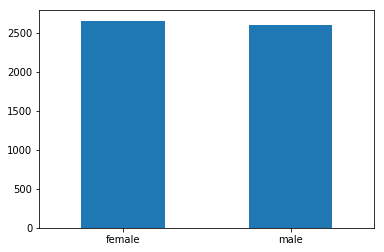

In [10]:
df['Gender'].value_counts().plot.bar(rot=0)
plt.show()

There are no null values in this column. As it can be seen, there the two genders present in the dataset are quite balanced.

**Age**

In [11]:
df['Age'].isna().sum()

0

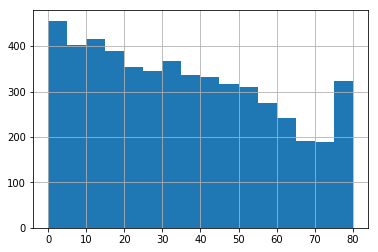

In [12]:
df['Age'].hist(bins=16)
plt.show()

No missing values. It can be observed that the age is not normally distributed in the dataset.

**Race**

In [13]:
df['Race1'].isna().sum()

0

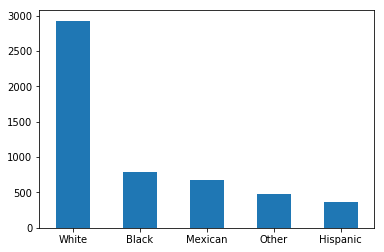

In [14]:
df['Race1'].value_counts().plot.bar(rot=0)
plt.show()

No missing values.

**Education**

In [15]:
df['Education'].isna().sum()

1672

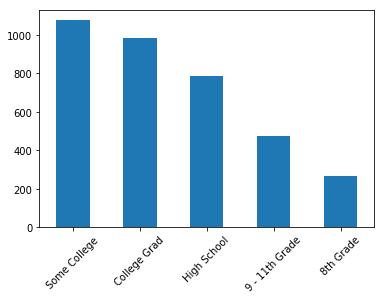

In [16]:
df['Education'].value_counts().plot.bar(rot=45)
plt.show()

In which age groups is the data missing?

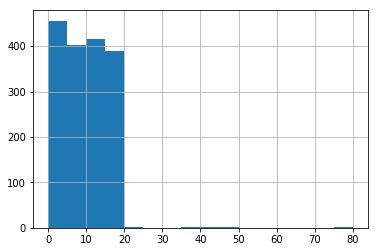

In [17]:
df.loc[df['Education'].isna()]['Age'].hist(bins=16)
plt.show()

1672 instance don't have a value in the 'Education' feature. It looks like this features tells at what point a given individual has stopped his/her education. This means that the dataset has missing values for young people that are still at school or at university. This could be changed into the education level that has been currently achieved by estimating in which education category each individual is. However there are still missing values for people that are older than 35 where it can be assumed that they have finished their education. 

**Marital Status**

In [18]:
df['MaritalStatus'].isna().sum()

1666

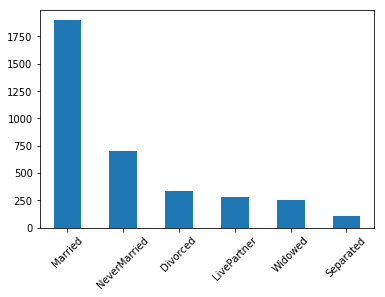

In [19]:
df['MaritalStatus'].value_counts().plot.bar(rot=45)
plt.show()

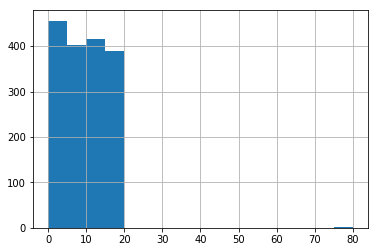

In [20]:
df.loc[df['MaritalStatus'].isna()]['Age'].hist(bins=16)
plt.show()

Similarly to the education example, most missing values arise from young indivuals where it can be assumed that they never married.

**HHIncome**

In [21]:
df['HHIncome'].isna().sum()

448

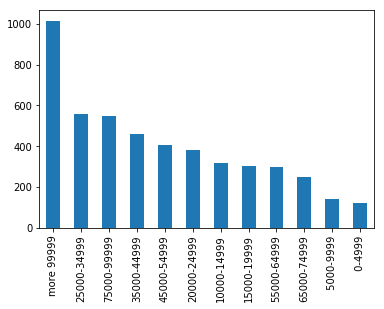

In [22]:
df['HHIncome'].value_counts().plot.bar(rot=90)
plt.show()

**HHIncomeMid**

In [23]:
df['HHIncomeMid'].isna().sum()

448

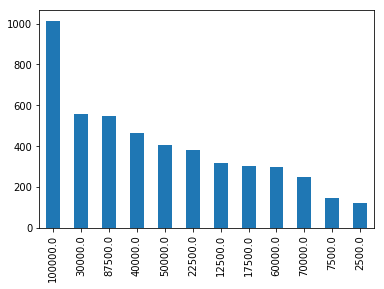

In [24]:
df['HHIncomeMid'].value_counts().plot.bar(rot=90)
plt.show()

**Poverty**

In [25]:
df['Poverty'].isna().sum()

403

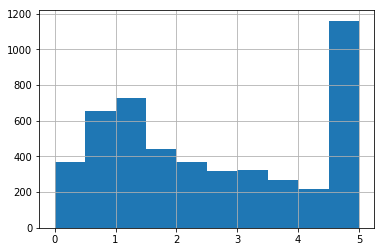

In [26]:
df['Poverty'].hist(bins=10)
plt.show()

**Home Rooms**

In [27]:
df['HomeRooms'].isna().sum()

36

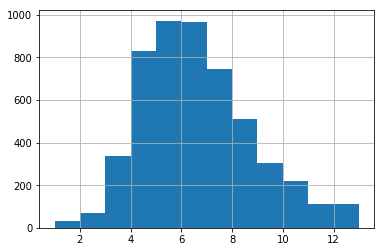

In [28]:
df['HomeRooms'].hist(bins=12)
plt.show()

The data appears to be normally distributed. There are very few data point missing. These could be filled in by looking at the average HomeRooms per income category.

**Home Own**

In [29]:
df['HomeOwn'].isna().sum()

33

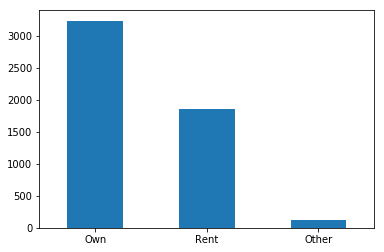

In [30]:
df['HomeOwn'].value_counts().plot.bar(rot=0)
plt.show()

Similarly, there are very few missing values which could be filled in the same way as HomeRoom.

**Work**

In [31]:
df['Work'].isna().sum()

1357

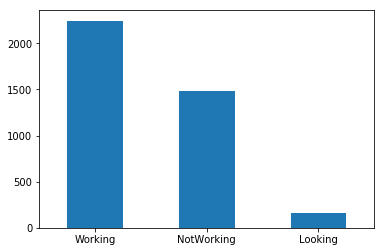

In [32]:
df['Work'].value_counts().plot.bar(rot=0)
plt.show()

In [33]:
len(df[(df['Work'].isna()) & (df['Education'].isna())])

1356

It looks like most of the individuals with missing values in the 'Work' column have not finished their education yet.

**Weight**

In [34]:
df['Weight'].isna().sum()

40

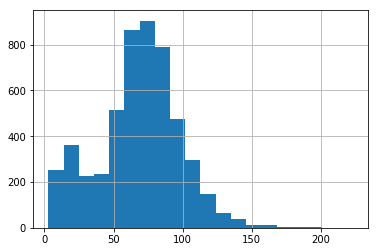

In [35]:
df['Weight'].hist(bins=20)
plt.show()

As there are few values missing they could also be filled in by using the mean of individuals grouped by age, sex and height.

**Length**

In [59]:
df['Length'].isna().sum()

4890

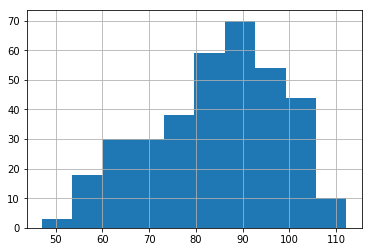

In [60]:
df['Length'].hist()
plt.show()

idk what this means. Maybe waistline circumference?

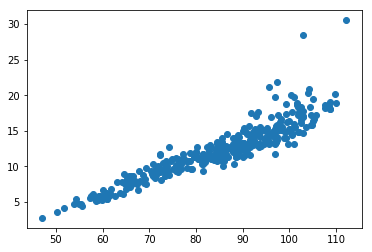

In [61]:
plt.scatter(x=df['Length'], y=df['Weight'])
plt.show()

**Head Circumference**

In [62]:
df['HeadCirc'].isna().sum()

5185

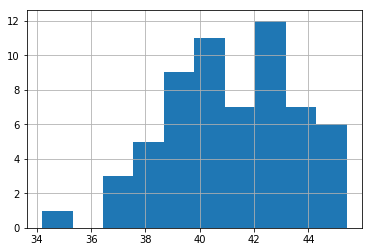

In [83]:
df['HeadCirc'].hist()
plt.show()

Lots of missing values. This feature could either be completely omitted.

**Height**

In [64]:
df['Height'].isna().sum()

232

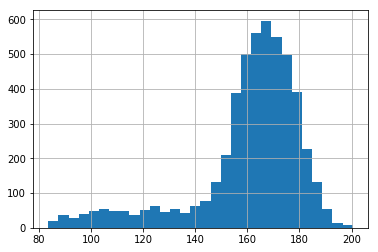

In [65]:
df['Height'].hist(bins=30)
plt.show()

The data appears to be normally distributed. There are some missing values that could be filled in by looking at the average for a given age and sex that the individual is part of.

**BMI**

In [66]:
df['BMI'].isna().sum()

236

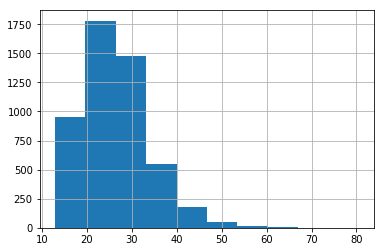

In [67]:
df['BMI'].hist()
plt.show()

In [68]:
len(df[(df['BMI'].isna()) & ((df['Height'].isna()) | df['Weight'].isna())])

236

These values cannot be filled in by using the weight and the height as where the BMI is missing, either the weight or height is also missing. 

**BMI Category Under 20 years**

In [69]:
df.loc[df['Age'] < 20]['BMICatUnder20yrs'].isna().sum()

941

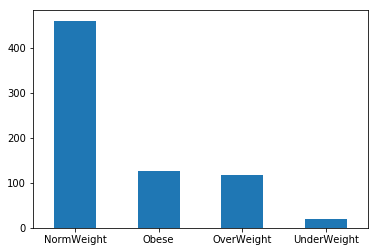

In [70]:
df['BMICatUnder20yrs'].value_counts().plot.bar(rot=0)
plt.show()

In [71]:
df.loc[df['Age'] >= 20]['BMICatUnder20yrs'].notna().sum()

0

All individuals with age $\ge 20$ correctly don't have a value in this column.
Missing values can be filled in by using the rispective data in the BMI column.


**BMI WHO**

In [72]:
df['BMI_WHO'].isna().sum()

256

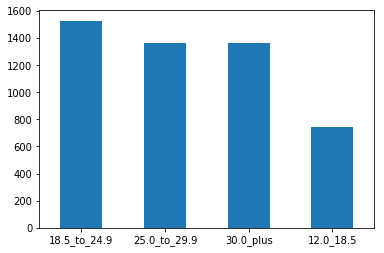

In [73]:
df['BMI_WHO'].value_counts().plot.bar(rot=0)
plt.show()

Similarly, missing values can be filled in by using the rispective data in the BMI column. Also these labels can be converted to the BMI categories. These are:
- Underweight
- Normal weight
- Overweight
- Obese

**Pulse**

In [74]:
df['Pulse'].isna().sum()

870

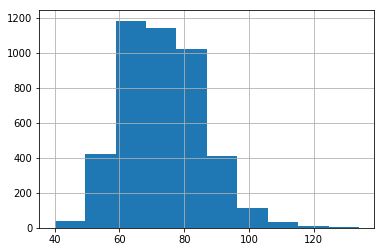

In [75]:
df['Pulse'].hist()
plt.show()

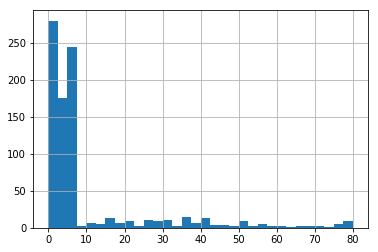

In [88]:
df.loc[df['Pulse'].isna()]['Age'].hist(bins=32)
plt.show()

870 missing values where moset of the are form people less or equal to 8 years old. They could be filled in probabilistically or this entire feature could be entirely omitted.

**BPSysAve**

**BPDiaAve**

**BPSys1**

**BPdDia1**

**BPSys2**

**BPdDia2**

**BPSys3**

**BPdDia3**

**Testosterone**

In [84]:
df['Testosterone'].isna().sum()

3238

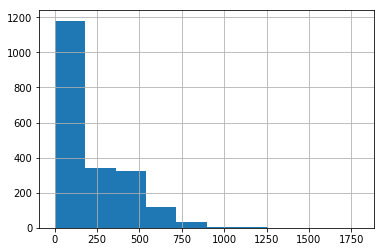

In [86]:
df['Testosterone'].hist()
plt.show()

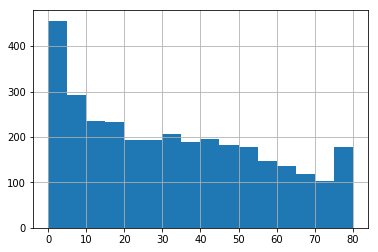

In [89]:
df.loc[df['Testosterone'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing values. This attribute could be completely omitted.

**DirectChol**

**TotChol**

**UrineVol1**

**UrineFlow1**

**UrineVol2**

**UrineFlow2**

**Diabetes**

In [90]:
df['Diabetes'].isna().sum()

103

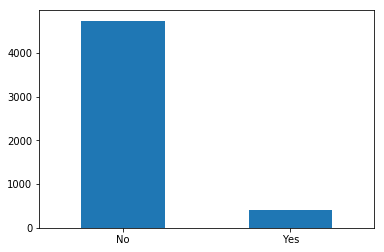

In [91]:
df['Diabetes'].value_counts().plot.bar(rot=0)
plt.show()

In [103]:
df.loc[df['Age'] < 1]['Diabetes'].isna().sum()

101

Most missing values are from babies where it can be assumed they are not obese. The remaining 2 could be filled in statistically.

**Diabetes Age**

In [107]:
len(df[(df['DiabetesAge'].isna()) & (df['Diabetes'].isna())])

103

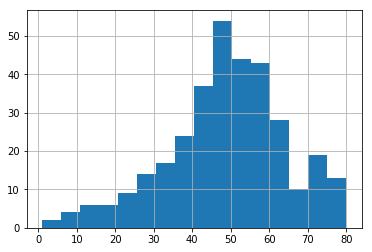

In [117]:
df['DiabetesAge'].hist(bins=16)
plt.show()

Most missing values for this features are because the individuals don't have diabetes. This means that the data is not actually missing but it is irrelevant. The instances where the data is actually missing are the same of the "Diabetes" feature.

**Health General**

In [109]:
df['HealthGen'].isna().sum()

1463

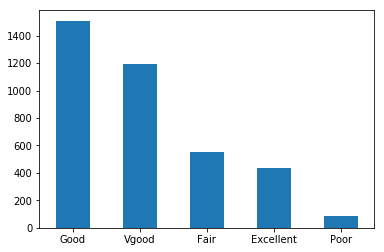

In [118]:
df['HealthGen'].value_counts().plot.bar(rot=0)
plt.show()

Many missing values which could be added using other features such as age and BMI.

**Days Mental Health Bad**

In [120]:
df['DaysMentHlthBad'].isna().sum()

1468

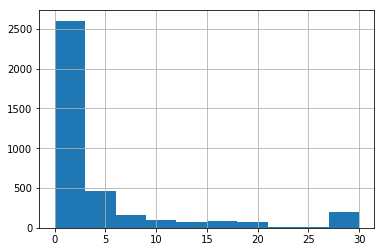

In [122]:
df['DaysMentHlthBad'].hist()
plt.show()

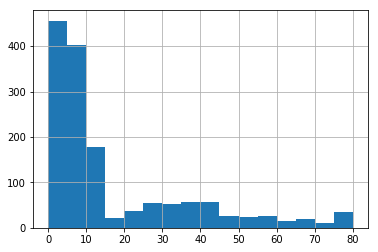

In [124]:
df.loc[df['DaysMentHlthBad'].isna()]['Age'].hist(bins=16)
plt.show()

Most missing values are in younger individuals. They can be added statistically.

**Little Interest**

In [127]:
df['LittleInterest'].isna().sum()

1954

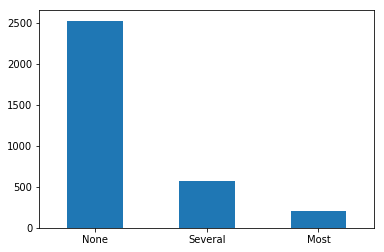

In [126]:
df['LittleInterest'].value_counts().plot.bar(rot=0)
plt.show()

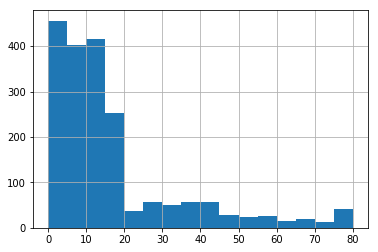

In [128]:
df.loc[df['LittleInterest'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing data but most of it is from the younger individuals. It could be assumed the people less than 10 years old have a value of None and the rest could be found statistically.

**Depressed**

In [129]:
df['Depressed'].isna().sum()

1951

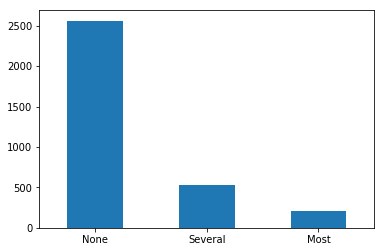

In [131]:
df['Depressed'].value_counts().plot.bar(rot=0)
plt.show()

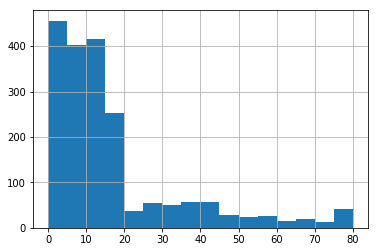

In [132]:
df.loc[df['Depressed'].isna()]['Age'].hist(bins=16)
plt.show()

In [ ]:
Similar situation to previous feature.

**Number Pregnancies**

In [146]:
len(df[(df['nPregnancies'].isna()) & (df['Gender']=='female')])

1370

In [140]:
len(df[df['nPregnancies']==0])

0

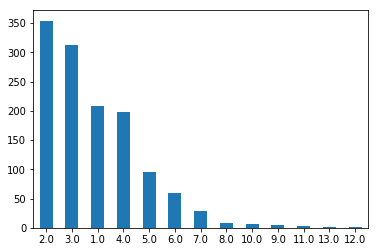

In [142]:
df['nPregnancies'].value_counts().plot.bar(rot=0)
plt.show()

In [143]:
len(df[(df['nPregnancies'].notna()) & (df['Gender']=='male')])

0

It looks like the data is not filled in if the individual has never had a pregnancy. As such it is hard to tell if data is actually missing where a person had a pregnancy but it is not recorded. As a sanity check, there are no males that have had a pregnancy.

**Number Babies**

In [144]:
len(df[(df['nPregnancies'].notna()) & (df['nBabies']).isna()])

101

In [150]:
len(df[df['nBabies']==0])

4

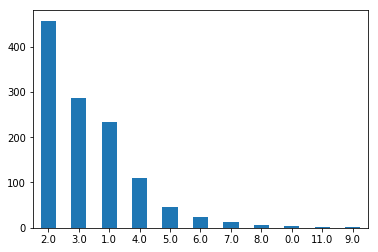

In [152]:
df['nBabies'].value_counts().plot.bar(rot=0)
plt.show()

How many instances have the amount of pregnancies different from the amount of babies?

In [160]:
len(df[(df['nPregnancies'] != df['nBabies']) & (df['nPregnancies'].notna()) & (df['nBabies'].notna())])

455

It looks like there are some missing values in this column. Unlike the "nPregnancies", the value 0 is actually used.

**Age 1st Baby**

In [162]:
len(df[(df['nBabies'].notna()) & (df['Age1stBaby']).isna()])

241

**Sleep Hours Night**

**Sleep Trouble**

**Physically Active**

**TV Hours per Day**

**Computer Hours per Day**

**TV Hours per Day Child**

**Computer Hours per Day Child**

**Alcohol 12+ Years**

**Alcohol Day**

**Alcohol Year**

**Smoke Now**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

**Diabetes**

### Analysing correlations between different features ###

**Between Height and Weight**

In [165]:
df[['Height', 'Weight']].corr()

,Height,Weight
Height,1.000000,0.759625
Weight,0.759625,1.000000


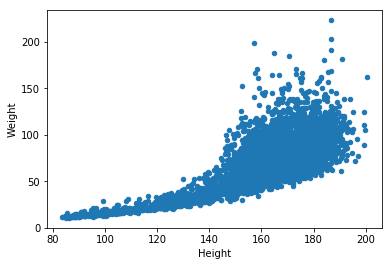

In [170]:
df.plot.scatter('Height', 'Weight')
plt.show()

Between HHincomeMid and HomeRooms

In [172]:
df[['HHIncomeMid', 'HomeRooms']].corr()

,HHIncomeMid,HomeRooms
HHIncomeMid,1.000000,0.458009
HomeRooms,0.458009,1.000000


## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

In [76]:
def expected_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [77]:
### fancy models that solve the problem

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [78]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [79]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [80]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set